## 01_cleaning
  

**Download the data from Chicago Data Portal and clean it**  

* The notebook creates a couple of local intermediate data files in tmp folder, that can be ignored


In [1]:
!pip install klib

  Obtaining dependency information for klib from https://files.pythonhosted.org/packages/76/20/7432265ee68ce3b8908a7ad892a61652ed95dfdc5e91b2e9d8becb5e348b/klib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.26.0 from https://files.pythonhosted.org/packages/47/7c/864cb966b96fce5e63fcf25e1e4d957fe5725a635e5f11fe03f39dd9d6b5/numpy-2.1.3-cp311-cp311-macosx_14_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
  Obtaining dependency information for plotly>=5.11.0 from https://files.pythonhosted.org/packages/e5/ae/580600f441f6fc05218bd6c9d5794f4aef072a7d9093b291f1c50a9db8bc/plotly-5.24.1-py3-none-any.whl.metadata
  Obtaining dependency information for screeninfo>=0.8.1 from https://files.pythonhosted.org/packages/6e/bf/c5205d480307bef660e56544b9e3d7ff687da776abb30c9cb3f330887570/screeninfo-0.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for numpy>=1.26.0 from https://files.pythonhosted.org/

In [2]:
import pandas as pd
import numpy as np
import klib
from platform import python_version

%precision 2
pd.set_option('display.precision',2)
pd.set_option('display.float_format','{:,.4f}'.format)

print('python',python_version())
print(np.__name__, np.__version__)
print(pd.__name__, pd.__version__)
print(klib.__name__, klib.__version__)

python 3.11.5
numpy 1.26.4
pandas 2.0.3
klib 1.3.2


# Download source data

The sequence of notebooks start from the direct raw download of data from the chicago data portal.

We worked with a snapshot downloaded on 2021-02-28, but the whole process is expected to be re-executable without any issues as in later stages we filter down the working data to just include the years of 2018,2019,2020, which are all in the past so we don't expect them to change.


We kept the download code commented out to prevent slowing down the process since we already had local copies.

# Read CSV file

In [8]:
df_raw = pd.read_csv('/Users/vamshikonapuram/Downloads/Traffic_Crashes_Crashes.csv').reset_index(drop=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889546 entries, 0 to 889545
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                889546 non-null  object 
 1   CRASH_DATE_EST_I               65774 non-null   object 
 2   CRASH_DATE                     889546 non-null  object 
 3   POSTED_SPEED_LIMIT             889546 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         889546 non-null  object 
 5   DEVICE_CONDITION               889546 non-null  object 
 6   WEATHER_CONDITION              889546 non-null  object 
 7   LIGHTING_CONDITION             889546 non-null  object 
 8   FIRST_CRASH_TYPE               889546 non-null  object 
 9   TRAFFICWAY_TYPE                889546 non-null  object 
 10  LANE_CNT                       199019 non-null  float64
 11  ALIGNMENT                      889546 non-null  object 
 12  ROADWAY_SURFACE_COND          

GridSpec(6, 6)

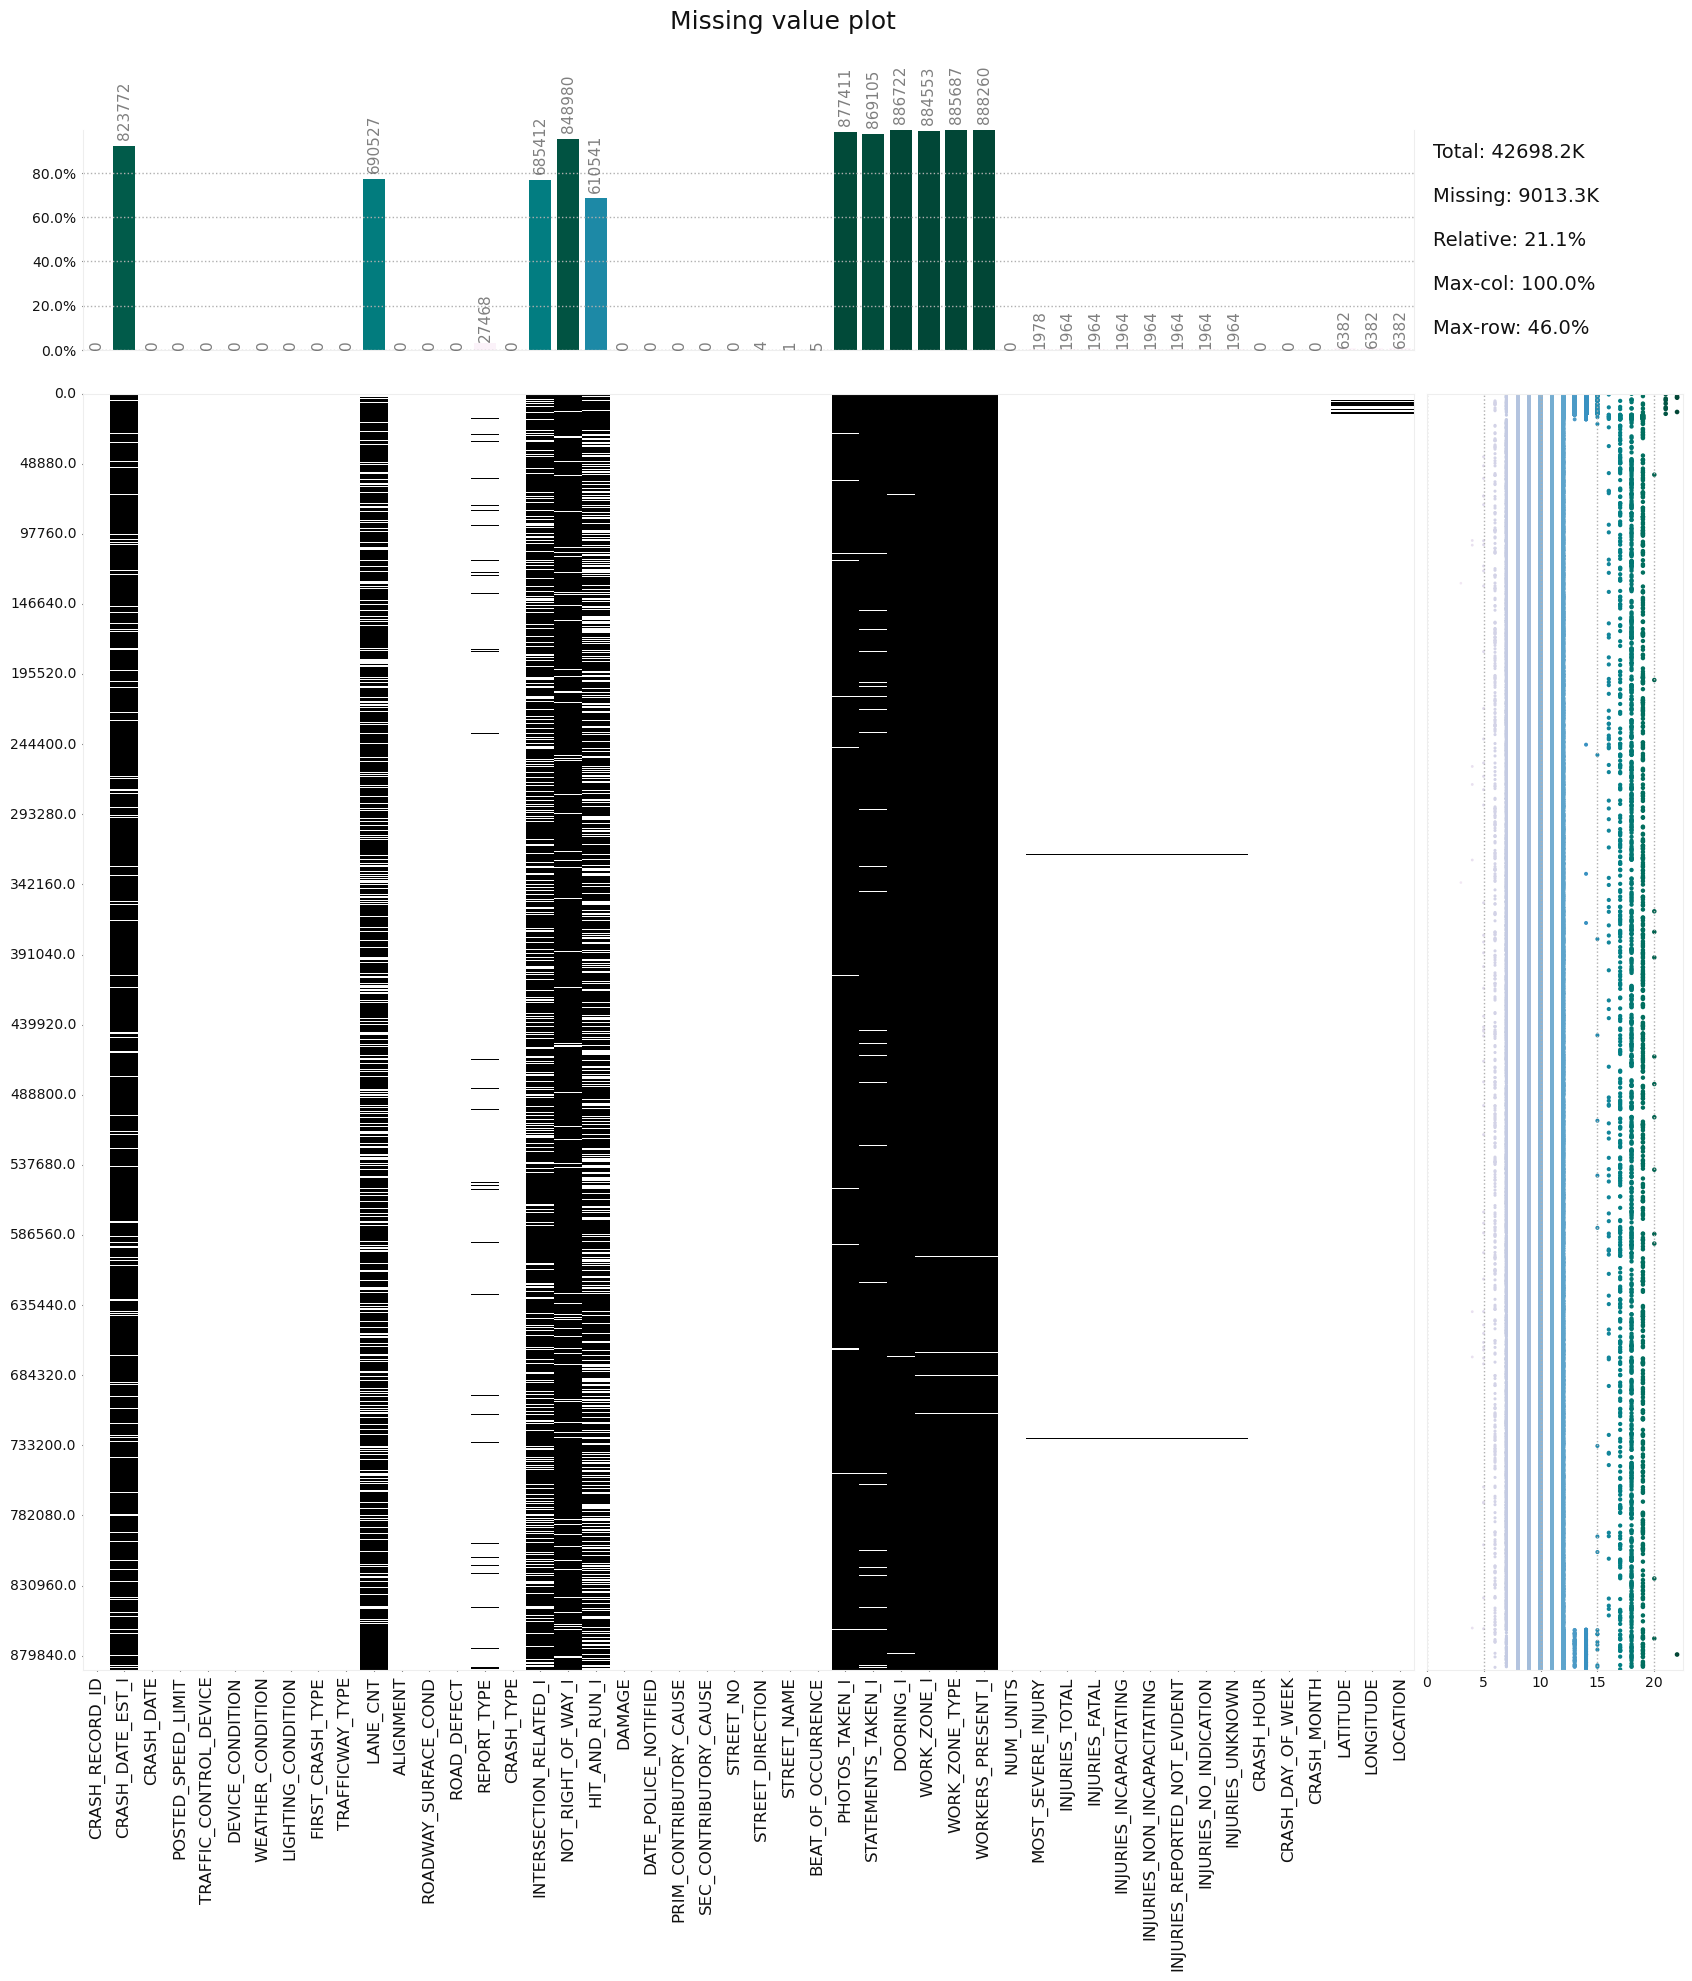

In [10]:
klib.missingval_plot(df_raw)

In [11]:
# Rename long columns
df_1 = df_raw.rename(columns={
    'INJURIES_NON_INCAPACITATING': 'INJ_NON_INCAP',
    'INJURIES_REPORTED_NOT_EVIDENT': 'INJ_REPORT_NOT_EVDNT'
})

# Drop unwanted columns
df_1.drop(columns=[
     'CRASH_DATE_EST_I', 'LANE_CNT', 'LOCATION', 'REPORT_TYPE', 'DATE_POLICE_NOTIFIED',
    'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I'
], inplace=True)


In [12]:
# Clean and standardize column names
df_c = klib.clean_column_names(df_1)

GridSpec(6, 6)

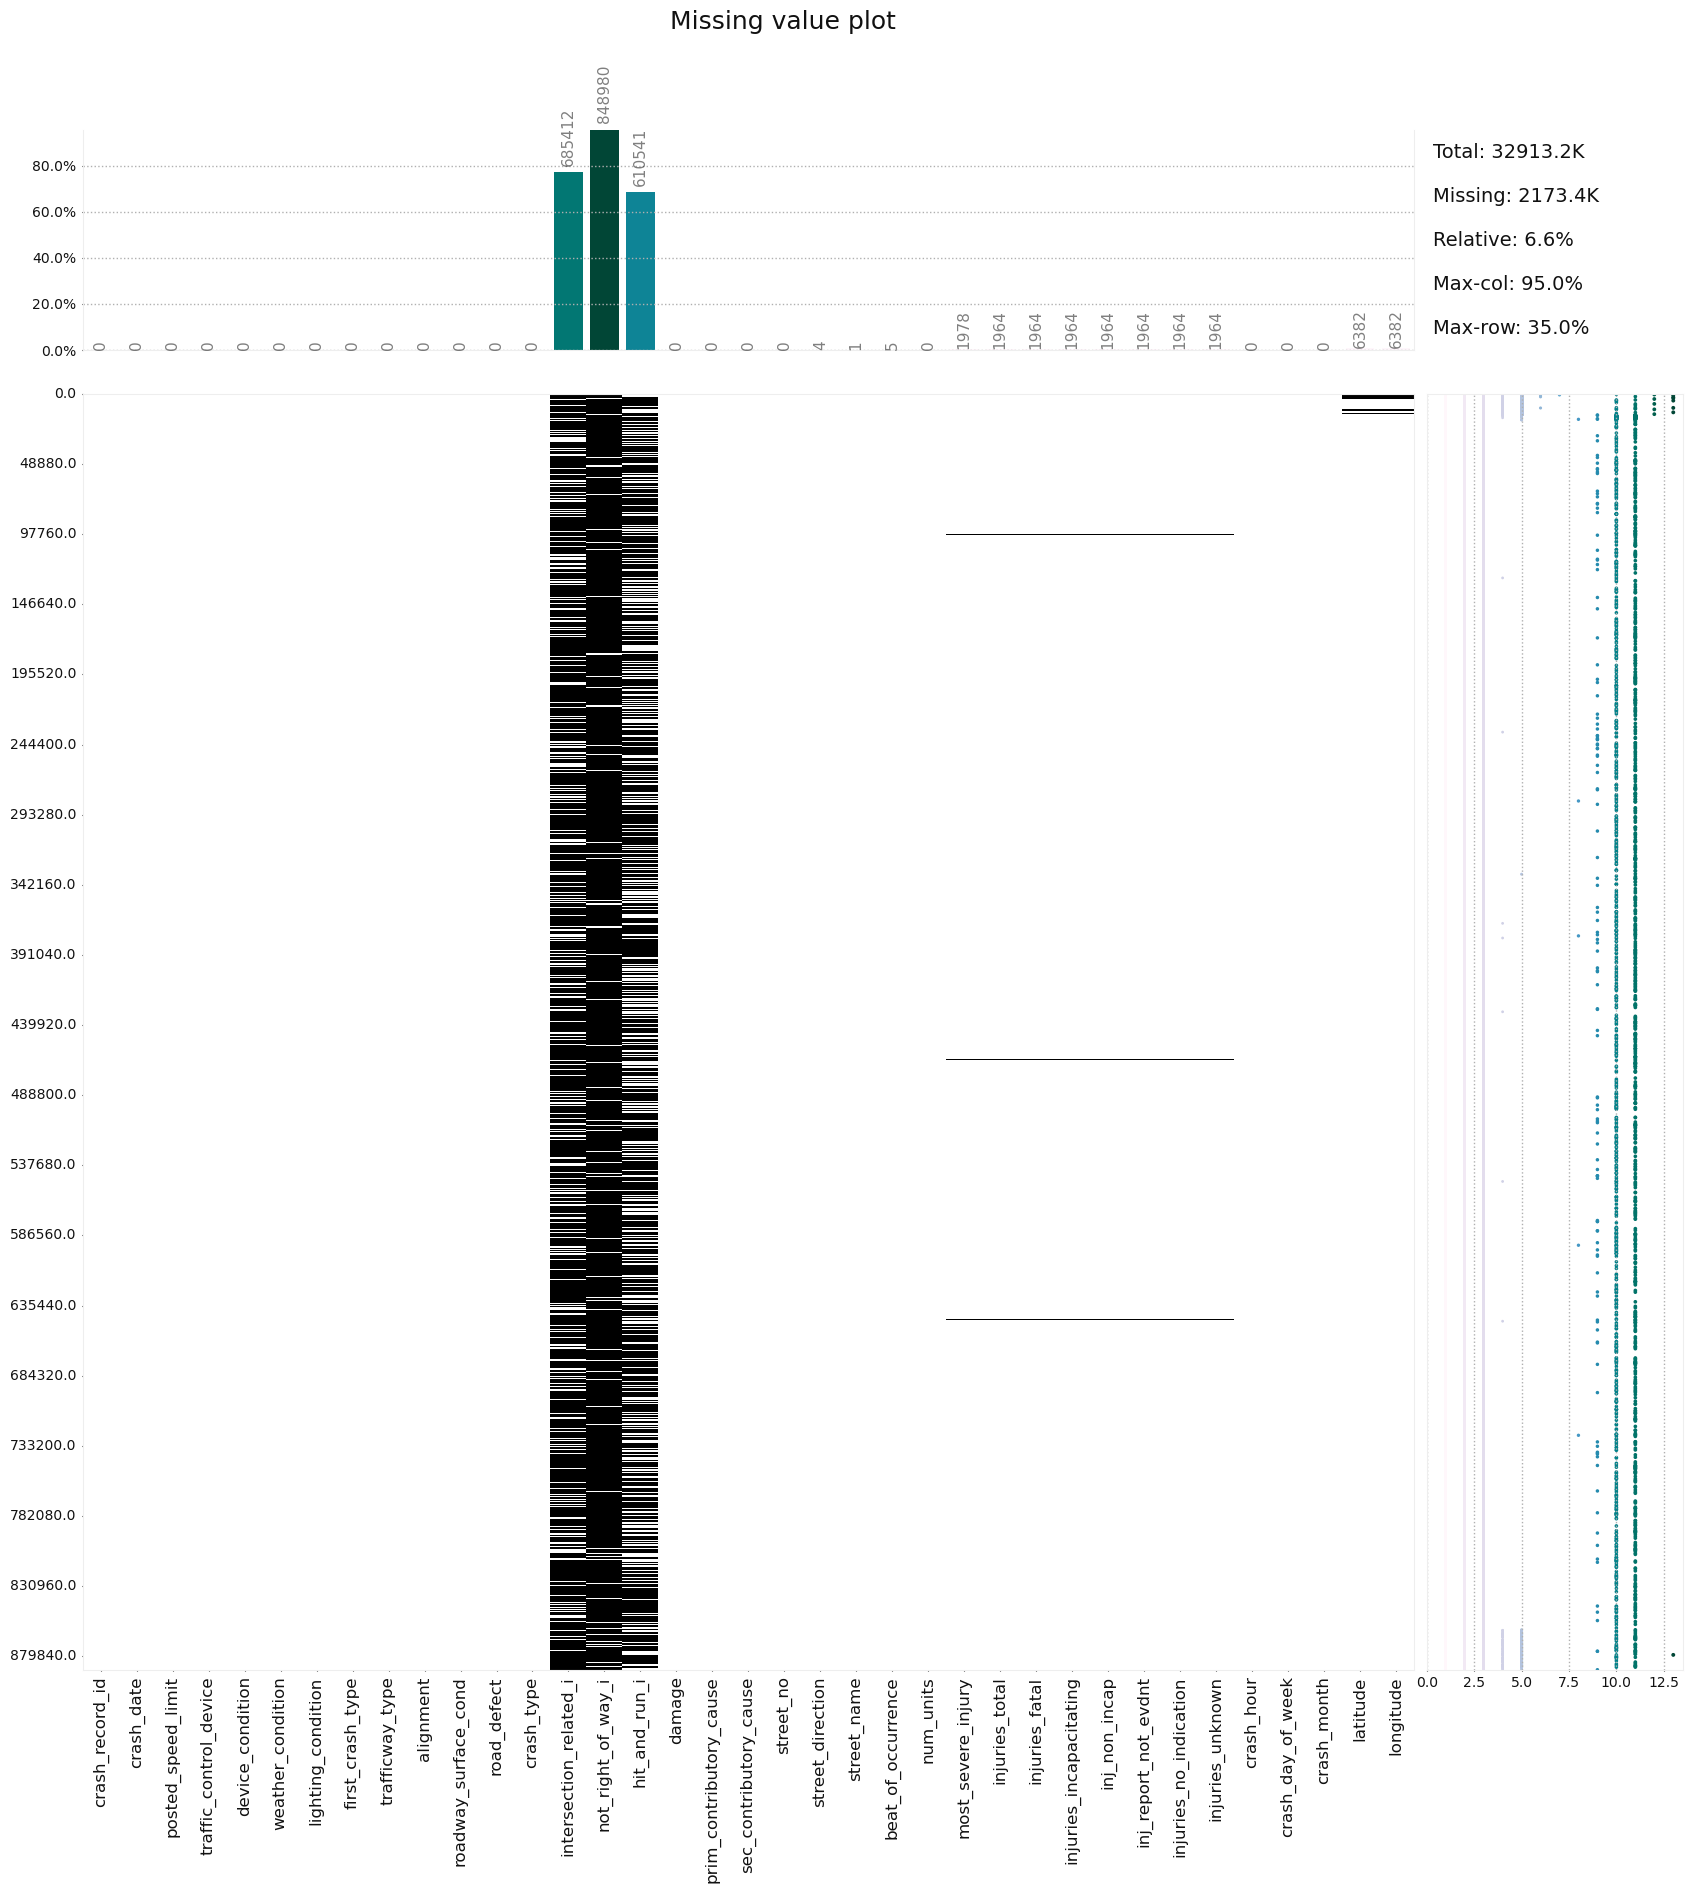

In [13]:
klib.missingval_plot(df_c)

In [14]:
# Fill missing values in these columns with N value, assuming it's the default
df_c.fillna({
    'intersection_related_i':'N',
    'not_right_of_way_i':'N',
    'hit_and_run_i':'N'
}, inplace=True)

GridSpec(6, 6)

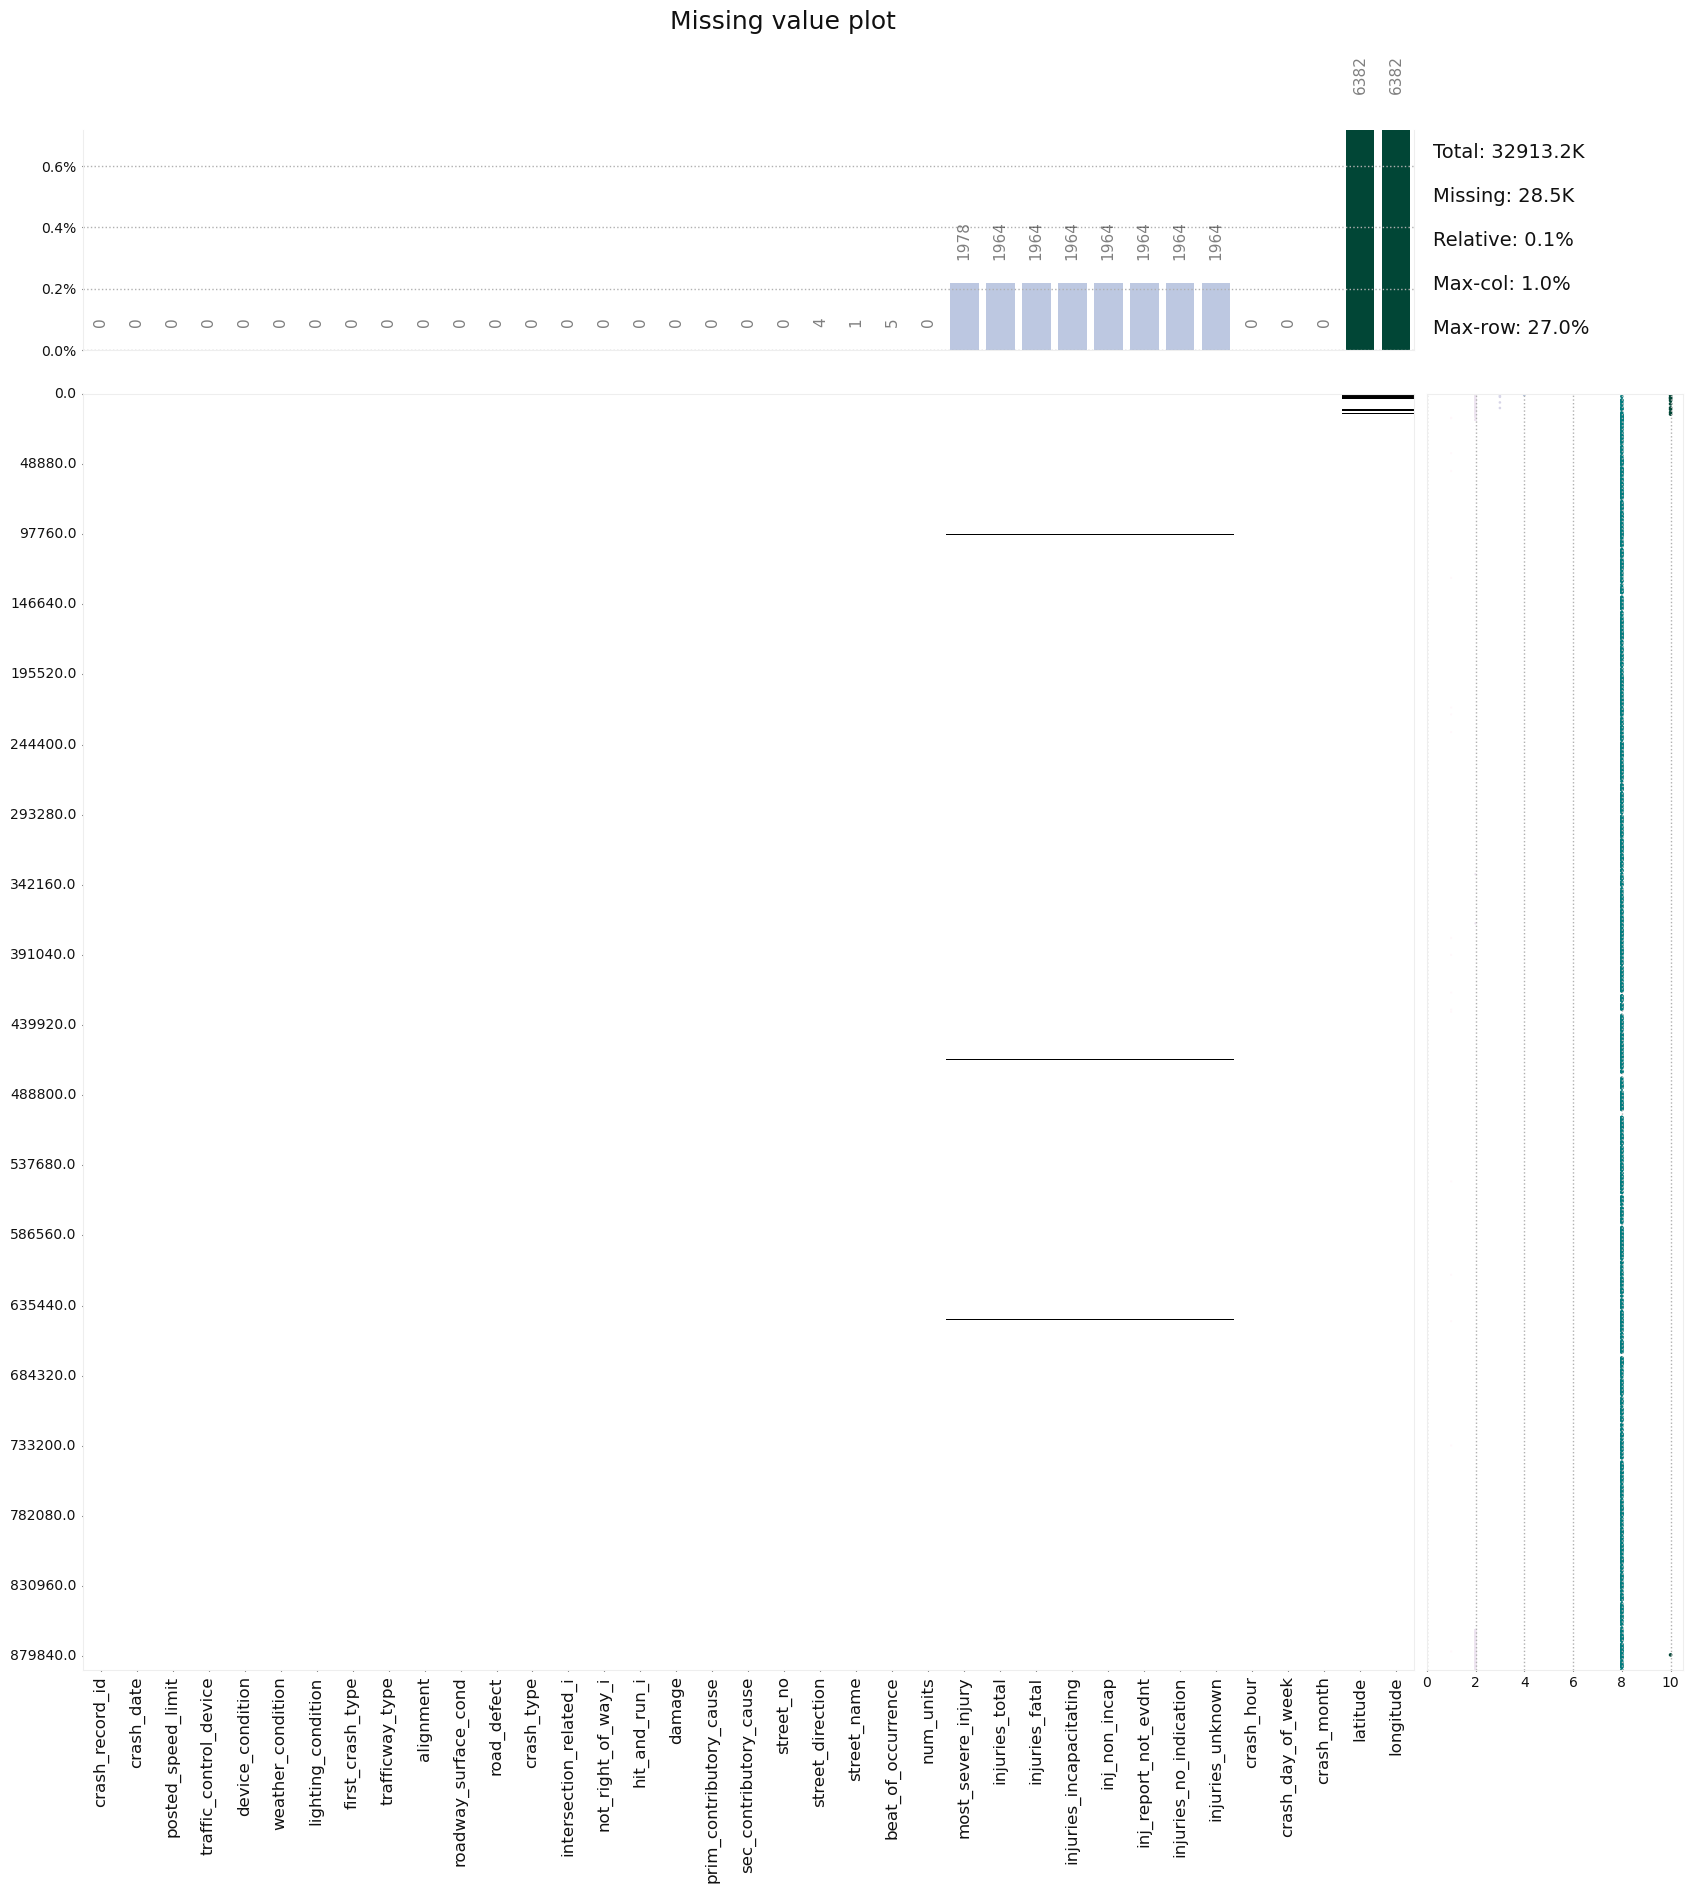

In [15]:
klib.missingval_plot(df_c)

In [16]:
# Set these columns to 0 wherever injuries_total is missing and crash_type is no injury
df_c.loc[((df_c.injuries_total.isna()) & (df_c.crash_type == 'NO INJURY / DRIVE AWAY')),[
          'injuries_total',
          'injuries_fatal',
          'injuries_incapacitating',
          'inj_non_incap',
          'inj_report_not_evdnt',
          'injuries_no_indication',
          'injuries_unknown'
         ]] = 0

In [17]:
# Drop rows where injuries_total is missing
df_c.drop(df_c[df_c.injuries_total.isna()].index, inplace=True)

In [18]:
# Set most_severe_injury = NO INDICATION OF INJURY,
# wherever most_severe_injury is missing and injuries_total is 0
df_c.loc[(df_c.most_severe_injury.isna()) & (df_c.injuries_total == 0),'most_severe_injury'] = 'NO INDICATION OF INJURY'

In [19]:
df_c.most_severe_injury.value_counts(dropna=False)

most_severe_injury
NO INDICATION OF INJURY     763867
NONINCAPACITATING INJURY     70196
REPORTED, NOT EVIDENT        38745
INCAPACITATING INJURY        14919
FATAL                          972
Name: count, dtype: int64

GridSpec(6, 6)

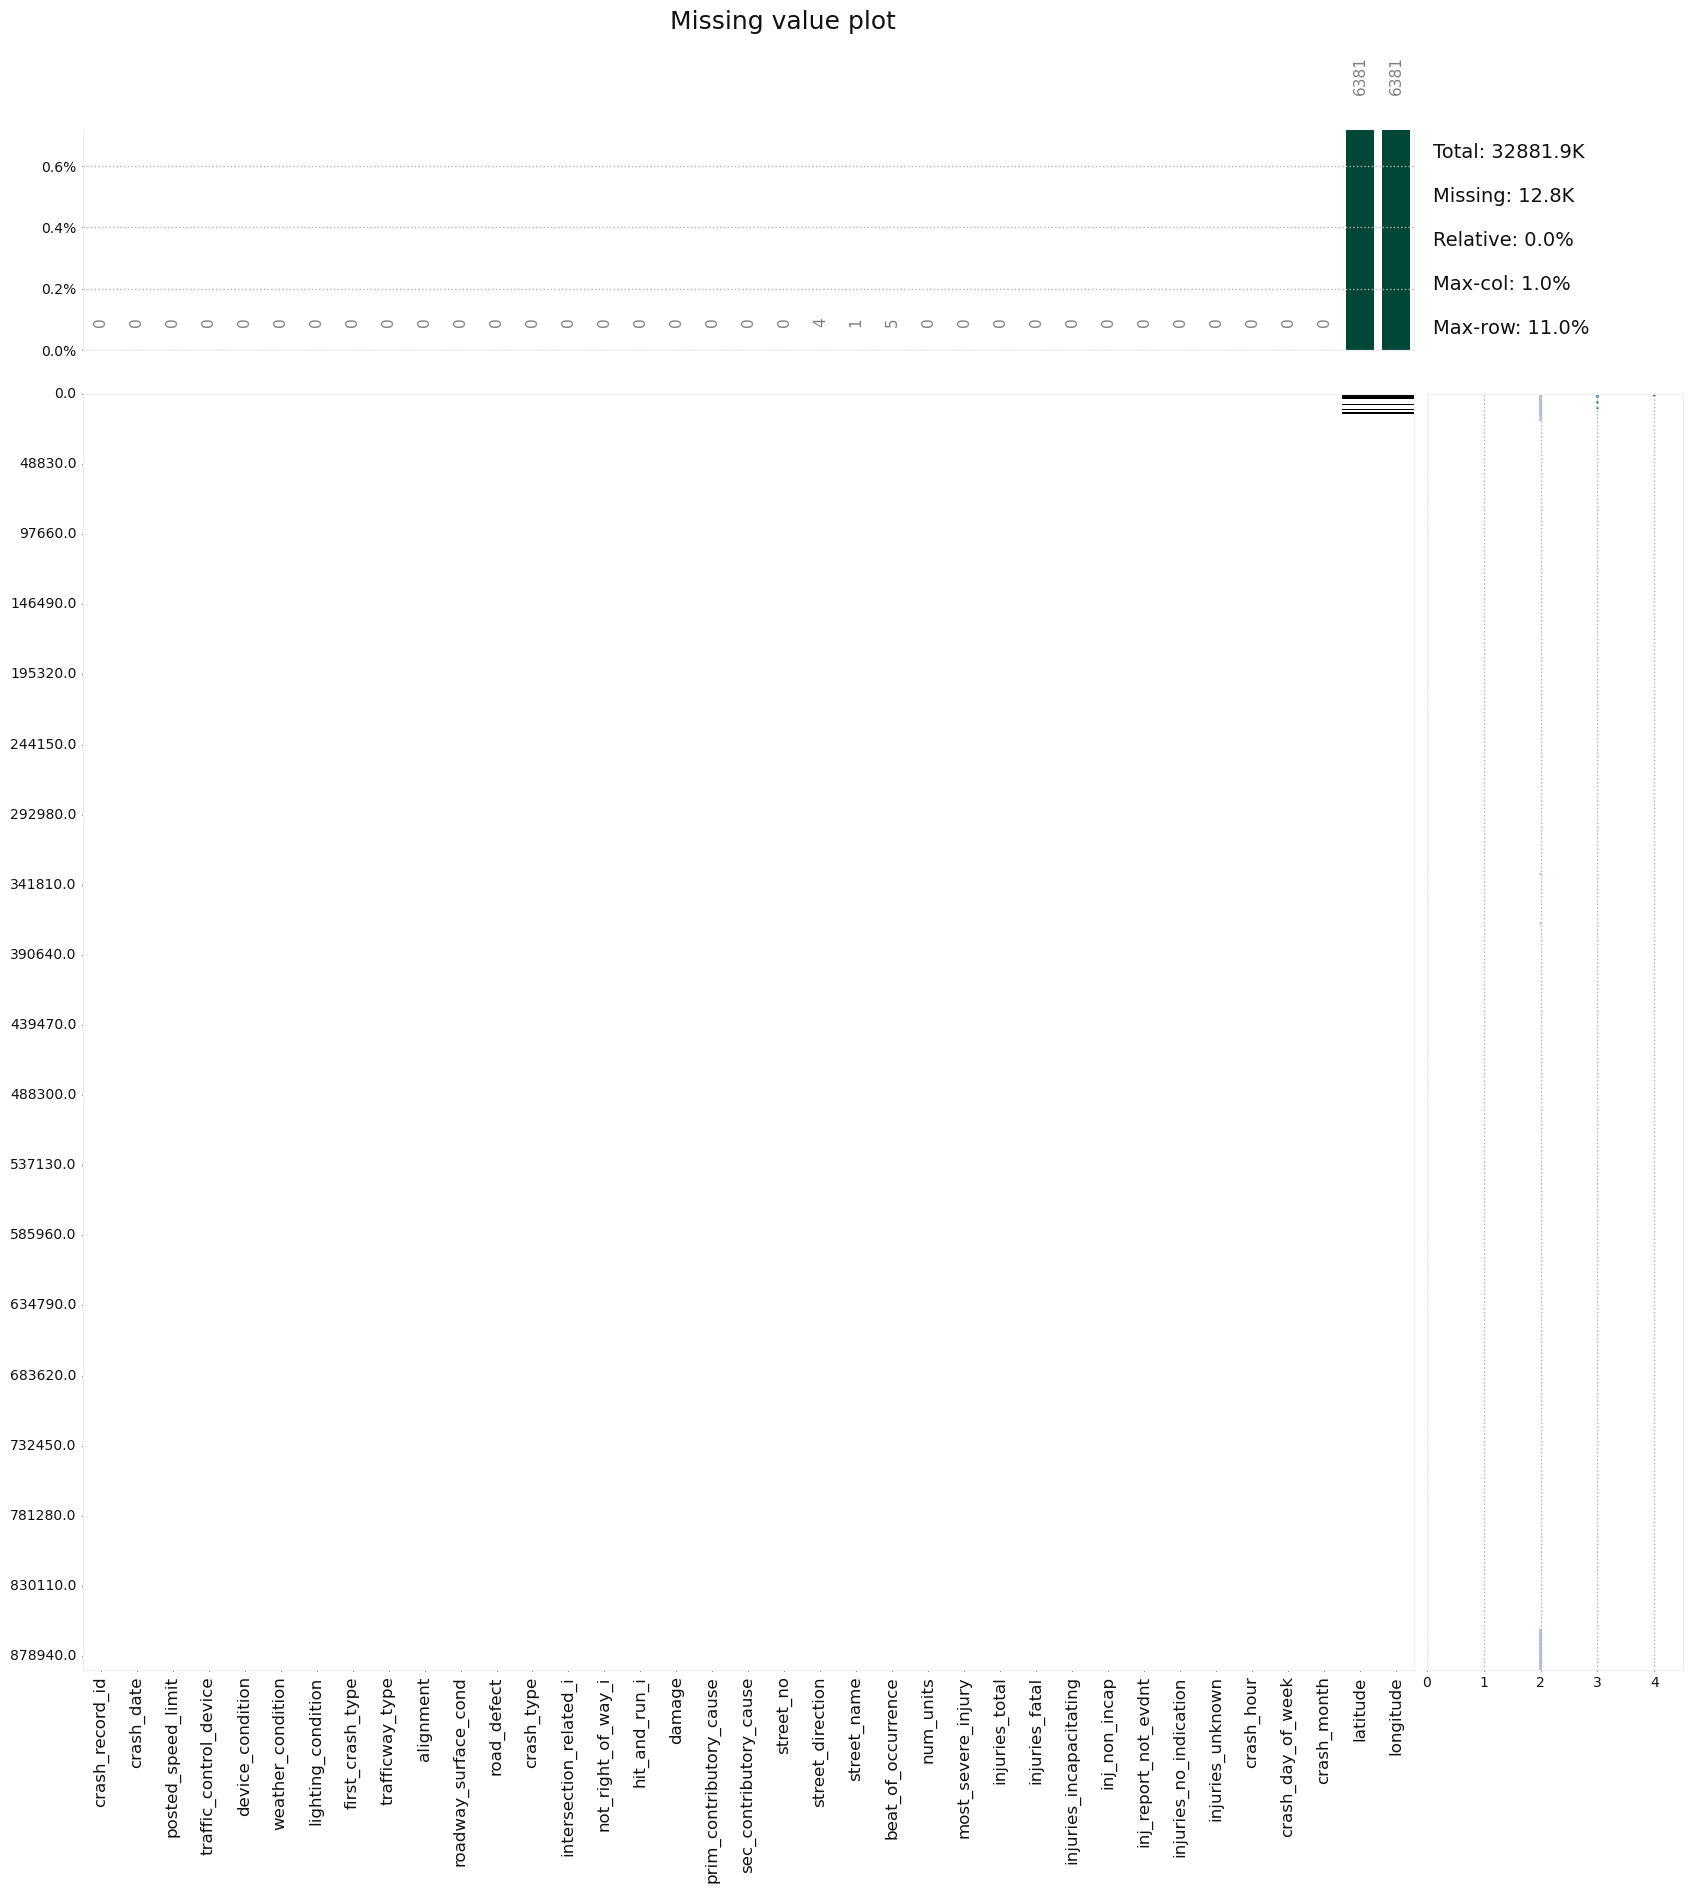

In [20]:
klib.missingval_plot(df_c)

In [21]:
# Fill missing beats

#df_c.loc[240890,'beat_of_occurrence'] = 712
#df_c.loc[304891,'beat_of_occurrence'] = 312
#df_c.loc[340159,'beat_of_occurrence'] = 1711

# Decided to drop records with missing beats. Not worth the step

In [22]:
import pandas as pd

# Ensure 'crash_date' is a datetime object
df_c['crash_date'] = pd.to_datetime(df_c['crash_date'])

# Create 'crash_year' column from 'crash_date'
df_c['crash_year'] = df_c['crash_date'].dt.year

# Convert 'street_no', 'street_direction', and 'street_name' to string
df_c['street_no'] = df_c['street_no'].astype(str)
df_c['street_direction'] = df_c['street_direction'].astype(str)
df_c['street_name'] = df_c['street_name'].astype(str)

# Create 'address' column by concatenating the street address components
df_c['address'] = df_c[['street_no', 'street_direction', 'street_name']].agg(' '.join, axis=1)


/var/folders/01/5bn1v1sj06s8zm7slnvqsn_40000gn/T/ipykernel_99084/1908958536.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_c['crash_date'] = pd.to_datetime(df_c['crash_date'])


In [23]:
# I will not drop duplicates, as they represent repeated incident characteristics, I think it's useful
df_c2 = klib.data_cleaning(df_c, drop_duplicates=False)

Shape of cleaned data: (888699, 38) - Remaining NAs: 12767


Dropped rows: 0
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 1
     of which 1 single valued.     Columns: ['injuries_unknown']
Dropped missing values: 0
Reduced memory by at least: 215.74 MB (-71.9%)



In [24]:
# drop rows that have both long and lat == 0
df_c2 = df_c2.query('latitude != 0 and longitude !=0')

In [25]:
# At this point, Drop any rows that still has NA's
df_c2.dropna(axis=0, inplace=True)

In [26]:
# Fix floats that should be int after we got rid of NA values
df_c2.beat_of_occurrence = df_c2.beat_of_occurrence.astype(int)
df_c2.injuries_total = df_c2.injuries_total.astype(int)
df_c2.injuries_fatal = df_c2.injuries_fatal.astype(int)
df_c2.injuries_incapacitating = df_c2.injuries_incapacitating.astype(int)
df_c2.inj_non_incap = df_c2.inj_non_incap.astype(int)
df_c2.inj_report_not_evdnt = df_c2.inj_report_not_evdnt.astype(int)
df_c2.injuries_no_indication = df_c2.injuries_no_indication.astype(int)


In [27]:
df_c2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 882263 entries, 2 to 889545
Data columns (total 38 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_record_id          882263 non-null  string        
 1   crash_date               882263 non-null  datetime64[ns]
 2   posted_speed_limit       882263 non-null  int8          
 3   traffic_control_device   882263 non-null  category      
 4   device_condition         882263 non-null  category      
 5   weather_condition        882263 non-null  category      
 6   lighting_condition       882263 non-null  category      
 7   first_crash_type         882263 non-null  category      
 8   trafficway_type          882263 non-null  category      
 9   alignment                882263 non-null  category      
 10  roadway_surface_cond     882263 non-null  category      
 11  road_defect              882263 non-null  category      
 12  crash_type           

In [28]:
klib.missingval_plot(df_c2)

No missing values found in the dataset.


In [29]:
df_c2

,crash_record_id,crash_date,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,inj_non_incap,inj_report_not_evdnt,injuries_no_indication,crash_hour,crash_day_of_week,crash_month,latitude,longitude,crash_year,address
2,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,2023-07-29 14:45:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,0,0,1,14,7,7,41.8541,-87.6659,2023,2101 S ASHLAND AVE
18,fd05285e9d273fe20cbbebf84794045828a2ba589073b6...,2023-07-29 14:30:00,10,NO CONTROLS,NO CONTROLS,UNKNOWN,UNKNOWN,ANGLE,PARKING LOT,STRAIGHT AND LEVEL,...,0,0,2,14,7,7,41.8098,-87.5942,2023,1320 E 47TH ST
19,fda2491d33ac819033f4aaa7ed901120f2f6785b7e5bbb...,2023-07-29 00:50:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DARKNESS,SIDESWIPE OPPOSITE DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,...,0,0,2,0,7,7,41.8992,-87.6966,2023,999 N CALIFORNIA AVE
27,4a1f7a24129e5e1d4a7a2fd44ab6f8822a20bcdb2f627f...,2023-08-13 10:10:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,...,0,0,4,10,1,8,41.9759,-87.7091,2023,3210 W FOSTER AVE
28,1ee2180a89cc02c0b756f95b5b2755bb5cc9d93450f5ca...,2023-08-09 19:55:00,30,TRAFFIC SIGNAL,FUNCTIONING IMPROPERLY,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,...,5,0,0,19,4,8,41.7582,-87.6265,2023,7458 S LAFAYETTE AVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889541,54d55bfcc6627f587abbe0d14c42e51b812f930566fb06...,2019-12-28 01:16:00,35,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,...,0,0,1,1,7,12,41.6851,-87.6286,2019,219 W 115TH ST
889542,2ee6209bde600a6ae2f12fb385b1e5749803cc01d0e954...,2023-05-29 21:40:00,30,UNKNOWN,UNKNOWN,CLEAR,DARKNESS,TURNING,OTHER,STRAIGHT AND LEVEL,...,0,0,2,21,2,5,41.8309,-87.6317,2023,3500 S WENTWORTH AVE
889543,f2c0204e5392ff379e5804ad25fad66304949d517327c6...,2020-10-18 00:03:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,...,0,0,4,0,1,10,41.7762,-87.7032,2020,6432 S KEDZIE AVE
889544,89dc61af34d393db950397f0cc06d53b56d1f5e5fa14d4...,2023-06-26 16:50:00,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,0,0,4,16,2,6,41.7469,-87.6441,2023,8100 S HALSTED ST


# Write final DF to csv

In [31]:
df_c2.to_csv('/Users/vamshikonapuram/Downloads/TC.csv')

In [32]:
crash_df = pd.read_csv('/Users/vamshikonapuram/Downloads/TC.csv')

In [33]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882263 entries, 0 to 882262
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               882263 non-null  int64  
 1   crash_record_id          882263 non-null  object 
 2   crash_date               882263 non-null  object 
 3   posted_speed_limit       882263 non-null  int64  
 4   traffic_control_device   882263 non-null  object 
 5   device_condition         882263 non-null  object 
 6   weather_condition        882263 non-null  object 
 7   lighting_condition       882263 non-null  object 
 8   first_crash_type         882263 non-null  object 
 9   trafficway_type          882263 non-null  object 
 10  alignment                882263 non-null  object 
 11  roadway_surface_cond     882263 non-null  object 
 12  road_defect              882263 non-null  object 
 13  crash_type               882263 non-null  object 
 14  inte

# Extra Steps

TODO
* [x] Round posted_speed_limit to nearest 5th unit
* [x] Create columns has_injuries and fatalaties
* [x] Drop date_police_notified (done at the top of the notebook)
* [x] Descretize crash_hour into  bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening']

In [34]:
_unit = 5 # rounding at mid-point to nearest _unit
crash_df.posted_speed_limit = crash_df.posted_speed_limit.apply(lambda x: (x//_unit*_unit) + round(x%_unit/_unit)*_unit)
crash_df.posted_speed_limit.value_counts()

posted_speed_limit
30     651952
35      58519
25      56175
20      36180
15      31016
10      20536
40       8485
0        7600
45       5650
5        5072
55        691
50        255
100        66
60         45
65         16
70          5
Name: count, dtype: int64

In [35]:
crash_df['has_injuries'] = crash_df.injuries_total.apply(lambda x: int(x>0))
crash_df['has_injuries'].value_counts()

has_injuries
0    758239
1    124024
Name: count, dtype: int64

In [36]:
crash_df['has_fatal'] = crash_df.injuries_fatal.apply(lambda x: int(x>0))
crash_df['has_fatal'].value_counts()

has_fatal
0    881298
1       965
Name: count, dtype: int64

In [37]:
crash_df['crash_time_of_day'] = pd.cut(crash_df.crash_hour, bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening'])
crash_df['crash_time_of_day'].value_counts()

crash_time_of_day
mid_day      368635
morning      260831
evening      150562
overnight    102235
Name: count, dtype: int64

# Write custom DF to csv

This is the data frame that has newly created featured and transformed values

In [38]:
features_names = [
    'crash_date',
    'crash_year',
    'crash_month',
    'crash_day_of_week',
    'crash_hour',
    'crash_time_of_day',
    'latitude',
    'longitude',
    'beat_of_occurrence',
    'address',
    'street_no',
    'street_direction',
    'street_name',
    'posted_speed_limit',
    'traffic_control_device',
    'device_condition',
    'weather_condition',
    'lighting_condition',
    'trafficway_type',
    'alignment',
    'roadway_surface_cond',
    'road_defect',
    'first_crash_type',
    'prim_contributory_cause',
    'sec_contributory_cause',
    'num_units'
]

target_names = [
    'has_injuries',
    'has_fatal', 
    'crash_type',
    'damage',
    'injuries_total',
    'injuries_fatal'
]

all_columns = features_names + target_names
all_columns

['crash_date',
 'crash_year',
 'crash_month',
 'crash_day_of_week',
 'crash_hour',
 'crash_time_of_day',
 'latitude',
 'longitude',
 'beat_of_occurrence',
 'address',
 'street_no',
 'street_direction',
 'street_name',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'first_crash_type',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'num_units',
 'has_injuries',
 'has_fatal',
 'crash_type',
 'damage',
 'injuries_total',
 'injuries_fatal']

In [41]:
file_crash_df = '/Users/vamshikonapuram/Downloads/crash_df.csv'

In [42]:
crash_df[all_columns].to_csv(file_crash_df)

# Read the clean data and select only the required features

In [43]:
crash_df = pd.read_csv('/Users/vamshikonapuram/Downloads/crash_df.csv')

In [44]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882263 entries, 0 to 882262
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               882263 non-null  int64  
 1   crash_date               882263 non-null  object 
 2   crash_year               882263 non-null  int64  
 3   crash_month              882263 non-null  int64  
 4   crash_day_of_week        882263 non-null  int64  
 5   crash_hour               882263 non-null  int64  
 6   crash_time_of_day        882263 non-null  object 
 7   latitude                 882263 non-null  float64
 8   longitude                882263 non-null  float64
 9   beat_of_occurrence       882263 non-null  int64  
 10  address                  882263 non-null  object 
 11  street_no                882263 non-null  int64  
 12  street_direction         882262 non-null  object 
 13  street_name              882263 non-null  object 
 14  post

In [45]:
crash_features = crash_df[features_names]
crash_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882263 entries, 0 to 882262
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   crash_date               882263 non-null  object 
 1   crash_year               882263 non-null  int64  
 2   crash_month              882263 non-null  int64  
 3   crash_day_of_week        882263 non-null  int64  
 4   crash_hour               882263 non-null  int64  
 5   crash_time_of_day        882263 non-null  object 
 6   latitude                 882263 non-null  float64
 7   longitude                882263 non-null  float64
 8   beat_of_occurrence       882263 non-null  int64  
 9   address                  882263 non-null  object 
 10  street_no                882263 non-null  int64  
 11  street_direction         882262 non-null  object 
 12  street_name              882263 non-null  object 
 13  posted_speed_limit       882263 non-null  int64  
 14  traf

In [46]:
crash_targets = crash_df[target_names]
crash_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 882263 entries, 0 to 882262
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   has_injuries    882263 non-null  int64 
 1   has_fatal       882263 non-null  int64 
 2   crash_type      882263 non-null  object
 3   damage          882263 non-null  object
 4   injuries_total  882263 non-null  int64 
 5   injuries_fatal  882263 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 40.4+ MB
